In [1]:
import os
from pathlib import Path
import glob
import openslide
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

# Select random slide

In [2]:
home_dir = os.getenv("HOME")
data_dir = os.path.join(home_dir, "datasets", "brca-psj-path")

table_dir = os.path.join(data_dir, "v2")

slide_dir = os.path.join(data_dir, "ndpi")
slides_fp = os.path.join(slide_dir, "*")
slides_list = glob.glob(slides_fp)

In [3]:
random.seed(123)
random_slide_path = random.choice(slides_list)
random_slide_id = Path(random_slide_path).stem

# Select random biopsy

Load slide biopsy map

In [4]:
slide_biopsy_map_fp = os.path.join(table_dir, "slide-biopsy-map.csv")
slide_biopsy_map_df = pd.read_csv(slide_biopsy_map_fp)

In [5]:
random.seed(123)
random_biopsy_id = random.choice(slide_biopsy_map_df["biopsy_id"].unique())
slide_ids = slide_biopsy_map_df[slide_biopsy_map_df["biopsy_id"] == random_biopsy_id][
    "slide_id"
].values
slide_ids.sort()

# Helper functions

In [6]:
def load_slide_biopsy_map():
    home_dir = os.getenv("HOME")
    data_dir = os.path.join(home_dir, "datasets", "brca-psj-path")
    table_dir = os.path.join(data_dir, "v2")
    slide_biopsy_map_fp = os.path.join(table_dir, "slide-biopsy-map.csv")
    slide_biopsy_map_df = pd.read_csv(slide_biopsy_map_fp)

    return slide_biopsy_map_df


def get_slide_file_path(slide_id):
    home_dir = os.getenv("HOME")
    data_dir = os.path.join(home_dir, "datasets", "brca-psj-path")
    slide_dir = os.path.join(data_dir, "ndpi")
    slide_fp = os.path.join(slide_dir, f"{slide_id}.ndpi")

    return slide_fp


def slide_paths_for_biopsy_id(biopsy_id):
    slide_biopsy_map_df = load_slide_biopsy_map()
    slide_id_list = slide_biopsy_map_df[slide_biopsy_map_df["biopsy_id"] == biopsy_id][
        "slide_id"
    ].values

    slide_paths = []
    for slide_id in slide_id_list:
        slide_path = get_slide_file_path(slide_id)
        slide_paths.append(slide_path)

    return slide_paths


def preview_slide(slide_path):
    slide_OS = openslide.OpenSlide(slide_path)
    lowest_res = slide_OS.level_dimensions[-1]

    return slide_OS.get_thumbnail(lowest_res)


def get_all_previews_for_biopsy_id(biopsy_id):
    preview_images = dict()
    slide_fp_list = slide_paths_for_biopsy_id(biopsy_id)
    print(f"This could take up to {len(slide_fp_list)*10} seconds.")

    for filepath in tqdm(slide_fp_list):
        slide_id = Path(filepath).stem
        preview_images[slide_id] = preview_slide(filepath)

    return preview_images


def show_slides_for_biopsy_id(biopsy_id, columns=3):
    preview_images = get_all_previews_for_biopsy_id(biopsy_id)
    img_count = len(preview_images)

    rows = math.ceil(img_count / columns)
    figsize = (columns * 7, rows * 7)

    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    axs = axs.flatten()
    for ax, (slide_id, img) in zip(axs, preview_images.items()):
        ax.imshow(img)
        ax.set_title(slide_id)
    for ax in axs:
        ax.axis("off")


def random_points(n, width, height, seed="123"):
    random.seed(seed)
    pts = []
    for _ in range(n):
        x = random.randrange(0, width - 256)
        y = random.randrange(0, height - 256)
        pts.append((x, y))

    return pts


def show_random_patches_slide(slide_id, seed="123"):
    slide_fp = get_slide_file_path(slide_id)
    slide_OS = openslide.OpenSlide(slide_fp)
    res = slide_OS.dimensions
    random_pts = random_points(15, *res, seed=seed)
    patch_size = (256, 256)

    display(preview_slide(slide_fp))

    pts = iter(random_pts)

    fig, axs = plt.subplots(5, 3, figsize=(15, 25))
    for i in range(5):
        for j in range(3):
            pt = next(pts)
            im = slide_OS.read_region(pt, 0, patch_size)
            axs[i, j].imshow(im)
            axs[i, j].axis("off")

# Preparing the Dataset

In [8]:
# Load the necessary data
slide_biopsy_map_fp = os.path.join(table_dir, "slide-biopsy-map.csv")
slide_biopsy_map_df = pd.read_csv(slide_biopsy_map_fp)

# Create a new DataFrame to store the mapping between slide and biopsy
slide_biopsy_mapping_df = slide_biopsy_map_df[["slide_id", "biopsy_id"]]

# Load the "outcomes.csv" file
outcomes_fp = os.path.join(table_dir, "outcomes.csv")
outcomes_df = pd.read_csv(outcomes_fp)

# Select the relevant columns from the outcomes DataFrame
selected_outcomes_columns = [
    "biopsy_id",
    "case_year",
    "patient_ngsci_id",
    "strict_metastatic_dx",
    "strict_metastatic_dx_dt",
    "biopsy_dt",
]

# Merge the slide-to-biopsy mapping DataFrame with the outcomes DataFrame
slide_biopsy_mapping_df = slide_biopsy_mapping_df.merge(
    outcomes_df[selected_outcomes_columns],
    on="biopsy_id",
    how="left",
)

# Display the new DataFrame
slide_biopsy_mapping_df.head()


,slide_id,biopsy_id,case_year,patient_ngsci_id,strict_metastatic_dx,strict_metastatic_dx_dt,biopsy_dt
0,4716c9f5-1eba-444a-9658-39c0cab80f05,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
1,7787542f-9bea-419b-b3fd-84de67ddc42e,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
2,cd87bcbf-9328-4747-8a05-4f14740bcf2f,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
3,6d9c5580-246b-4c29-a61f-674a2c07a556,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
4,d9b7ae2c-bb42-434a-93a4-70fe23e7f282,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15


In [9]:
len(slide_biopsy_mapping_df['slide_id'].unique())

52262

In [10]:
df = slide_biopsy_mapping_df
total_metastatic_dx = df["strict_metastatic_dx"].sum()

print("Total Metastatic Diagnoses:", total_metastatic_dx)

Total Metastatic Diagnoses: 3910


In [11]:
def show_slides_for_slide_id(slide_id, columns=3):
    slide_path = get_slide_file_path(slide_id)
    preview_image = preview_slide(slide_path)

    if preview_image is not None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        ax.imshow(preview_image)
        ax.set_title(slide_id)
        ax.axis("off")
    else:
        print(f"No image found for slide ID: {slide_id}")

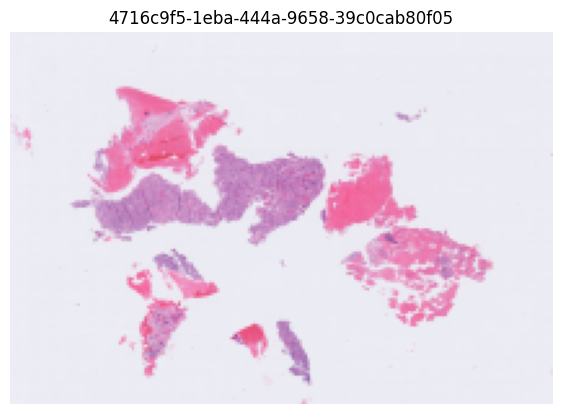

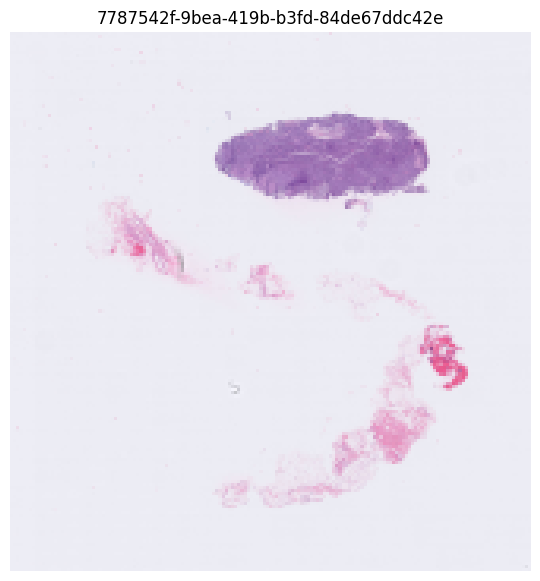

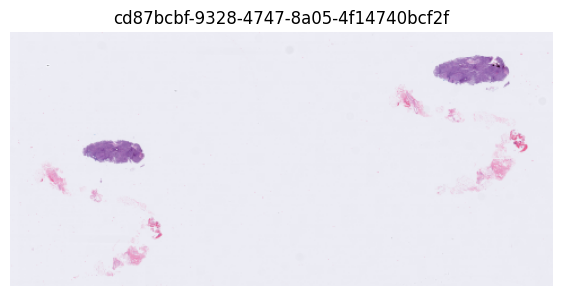

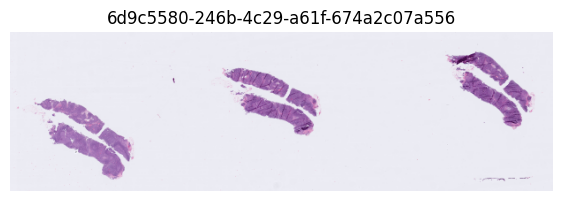

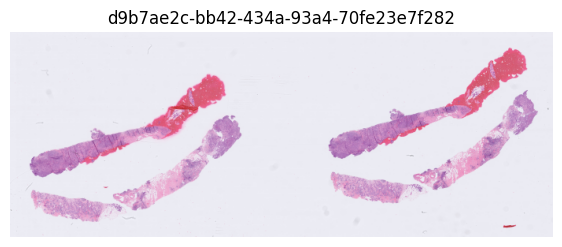

In [12]:
# Get the first 5 unique slide IDs from the DataFrame
first_5_slide_ids = slide_biopsy_map_df["slide_id"].unique()[:5]

# Display the images for the first 5 slide IDs one by one
for slide_id in first_5_slide_ids:
    show_slides_for_slide_id(slide_id, columns=1)

# Filtering

In [13]:
mask = slide_biopsy_mapping_df["strict_metastatic_dx_dt"] < slide_biopsy_mapping_df["biopsy_dt"]

# Use the mask to filter and keep only the rows where the condition is False (i.e., dx_dt is not before biopsy_dt)
filtered_df = slide_biopsy_mapping_df[~mask]

# Display the filtered DataFrame
filtered_df.head()

,slide_id,biopsy_id,case_year,patient_ngsci_id,strict_metastatic_dx,strict_metastatic_dx_dt,biopsy_dt
0,4716c9f5-1eba-444a-9658-39c0cab80f05,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
1,7787542f-9bea-419b-b3fd-84de67ddc42e,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
2,cd87bcbf-9328-4747-8a05-4f14740bcf2f,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
3,6d9c5580-246b-4c29-a61f-674a2c07a556,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
4,d9b7ae2c-bb42-434a-93a4-70fe23e7f282,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15


In [14]:
len(filtered_df)

51487

In [136]:
df = filtered_df
total_metastatic_dx = df["strict_metastatic_dx"].sum()

print("Total Metastatic Diagnoses:", total_metastatic_dx)

Total Metastatic Diagnoses: 3135


In [20]:
final_df = filtered_df.head(500)

# Model Preparation

In [113]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import openslide
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
image_paths = final_df["slide_id"].tolist()
labels = final_df["strict_metastatic_dx"].tolist()

def process_path(slide_id):
    slide_path = get_slide_file_path(slide_id)
    preview_image = preview_slide(slide_path)
    if preview_image is not None:
        image = np.array(preview_image)  # Convert to numpy array
        image = tf.image.resize(image, (224, 224))
        return image

# Creating TensorFlow Dataset
def create_dataset(image_paths):
    paths = []
    for i in range(len(image_paths)):
        paths.append(process_path(image_paths[i]))
    return paths

# load images of slides
images = np.array(create_dataset(image_paths)) 
print("Images Uploaded")

Images Uploaded


In [80]:
# Shuffle the data to generate a random permutation of indices and apply it to both images and labels
indices = np.arange(len(labels))
np.random.shuffle(indices)
shuffled_images = images[indices]
shuffled_labels = labels[indices]

# Split the shuffled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(shuffled_images, shuffled_labels, test_size=0.2, random_state=42)

In [111]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Path to the manually downloaded weights file
weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load ResNet50 model without top layer and load the weights from the downloaded file
base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
base_model.load_weights(weights_path)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
batch_size = 16
num_epochs = 10
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(len(X_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
          
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, class_weight=class_weight_dict, callbacks=[early_stopping])

# Get predictions
y_pred_prob = model.predict(test_dataset)
y_pred_classes = (y_pred_prob > 0.45).astype(int).reshape(-1)  # Threshold adjusted as per requirement

# Convert y_test to numpy array for metrics calculation
y_true = np.array(y_test)

Epoch 1/10


2023-12-12 09:52:33.669867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [2]
	 [[{{node Placeholder/_11}}]]
2023-12-12 09:52:33.670210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [2]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - ETA: 0s - loss: 56.7334 - accuracy: 0.6550

2023-12-12 09:52:50.961037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [100]
	 [[{{node Placeholder/_1}}]]


25/25 [==============================] - 20s 693ms/step - loss: 56.7334 - accuracy: 0.6550 - val_loss: 10.0738 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 16s 647ms/step - loss: 25.2911 - accuracy: 0.7550 - val_loss: 9.3853 - val_accuracy: 0.8700
Epoch 3/10
25/25 [==============================] - 16s 646ms/step - loss: 12.5294 - accuracy: 0.8300 - val_loss: 8.9511 - val_accuracy: 0.8900
Epoch 4/10
25/25 [==============================] - 16s 651ms/step - loss: 14.8951 - accuracy: 0.9000 - val_loss: 8.7461 - val_accuracy: 0.9100
Epoch 5/10
25/25 [==============================] - 16s 639ms/step - loss: 17.7533 - accuracy: 0.8650 - val_loss: 9.5320 - val_accuracy: 0.8500
Epoch 6/10
25/25 [==============================] - 16s 650ms/step - loss: 8.4754 - accuracy: 0.9175 - val_loss: 8.2051 - val_accuracy: 0.9300
Epoch 7/10
25/25 [==============================] - 16s 646ms/step - loss: 8.8440 - accuracy: 0.9025 - val_loss: 7.4839 - val_accuracy: 0.9400
Epoc

# Model Performance & Analytics

In [127]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)  # Same as sensitivity
specificity = TN / (TN + FP)
f1 = f1_score(y_true, y_pred_classes)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Print evaluation metrics
print("Model Metrics:\n")
print(f"1. Accuracy: {accuracy:.2f}")
print(f"2. Precision: {precision:.2f}")
print(f"3. Recall (Sensitivity): {recall:.4f}")
print(f"4. Specificity: {specificity:.4f}")
print(f"5. F1 Score: {f1:.4f}")
print(f"6. ROC AUC Score: {roc_auc:.4f}")

Model Metrics:

1. Accuracy: 0.87
2. Precision: 0.58
3. Recall (Sensitivity): 0.8235
4. Specificity: 0.8795
5. F1 Score: 0.6829
6. ROC AUC Score: 0.9235


In [132]:
print("Naive Approach Accuracy: " + str(1-y_test.sum()/len(y_test)) + "  <<  0.87 showing model out performs naive approach")

Naive Approach Accuracy: 0.83  <<  0.87 showing model out performs naive approach


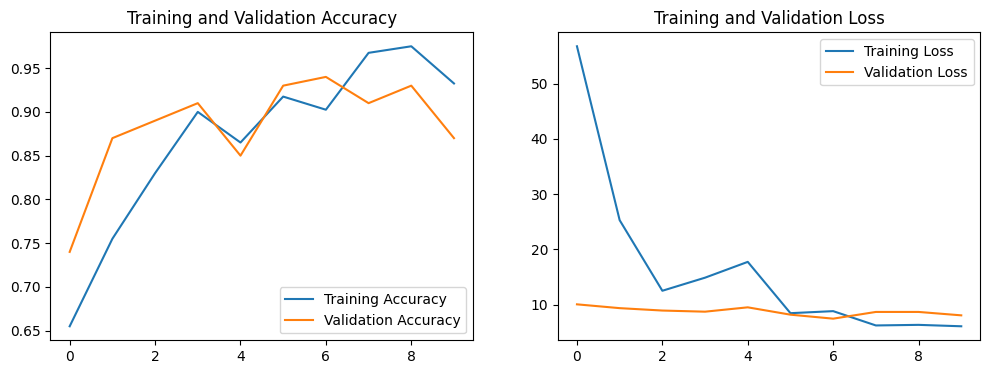

In [133]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(num_epochs)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

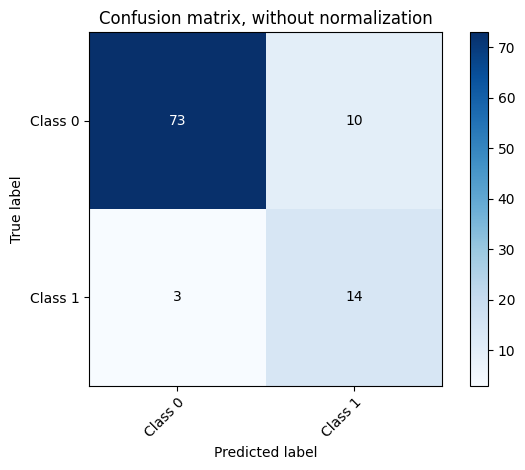

In [135]:
plot_confusion_matrix(y_true, y_pred_classes, classes=['Class 0', 'Class 1'], normalize=False)
plt.show()